# Try `GeluSigmoid` learning

Observations from `g_true.ipynb` show that on the domain $x\in [0,1]$ the range $g(x)$ achieves max and min values outside $[-1,1]$. 
Which exceeds the output range of `tanh` outlayer in `Gelu`

In [1]:
import torch 
import numpy as np

from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

from data.budworm import simulate_trials
from stabnode.utils import set_global_seed
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('ggplot')


seed = 1234
set_global_seed(seed=seed)


savefigs = True
folder = "figures_g_sigmoid/"

## Generate data for each trial

In [2]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
print(r1,r2)

k1 = r1-1.1
k2 = r2+1.1

def smooth_k(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

def smooth_k_torch(t):
    A = (k2-k1)/2
    return A*torch.sin(t-torch.pi/2) + A + k1

6.44569072482332 9.93441120446710


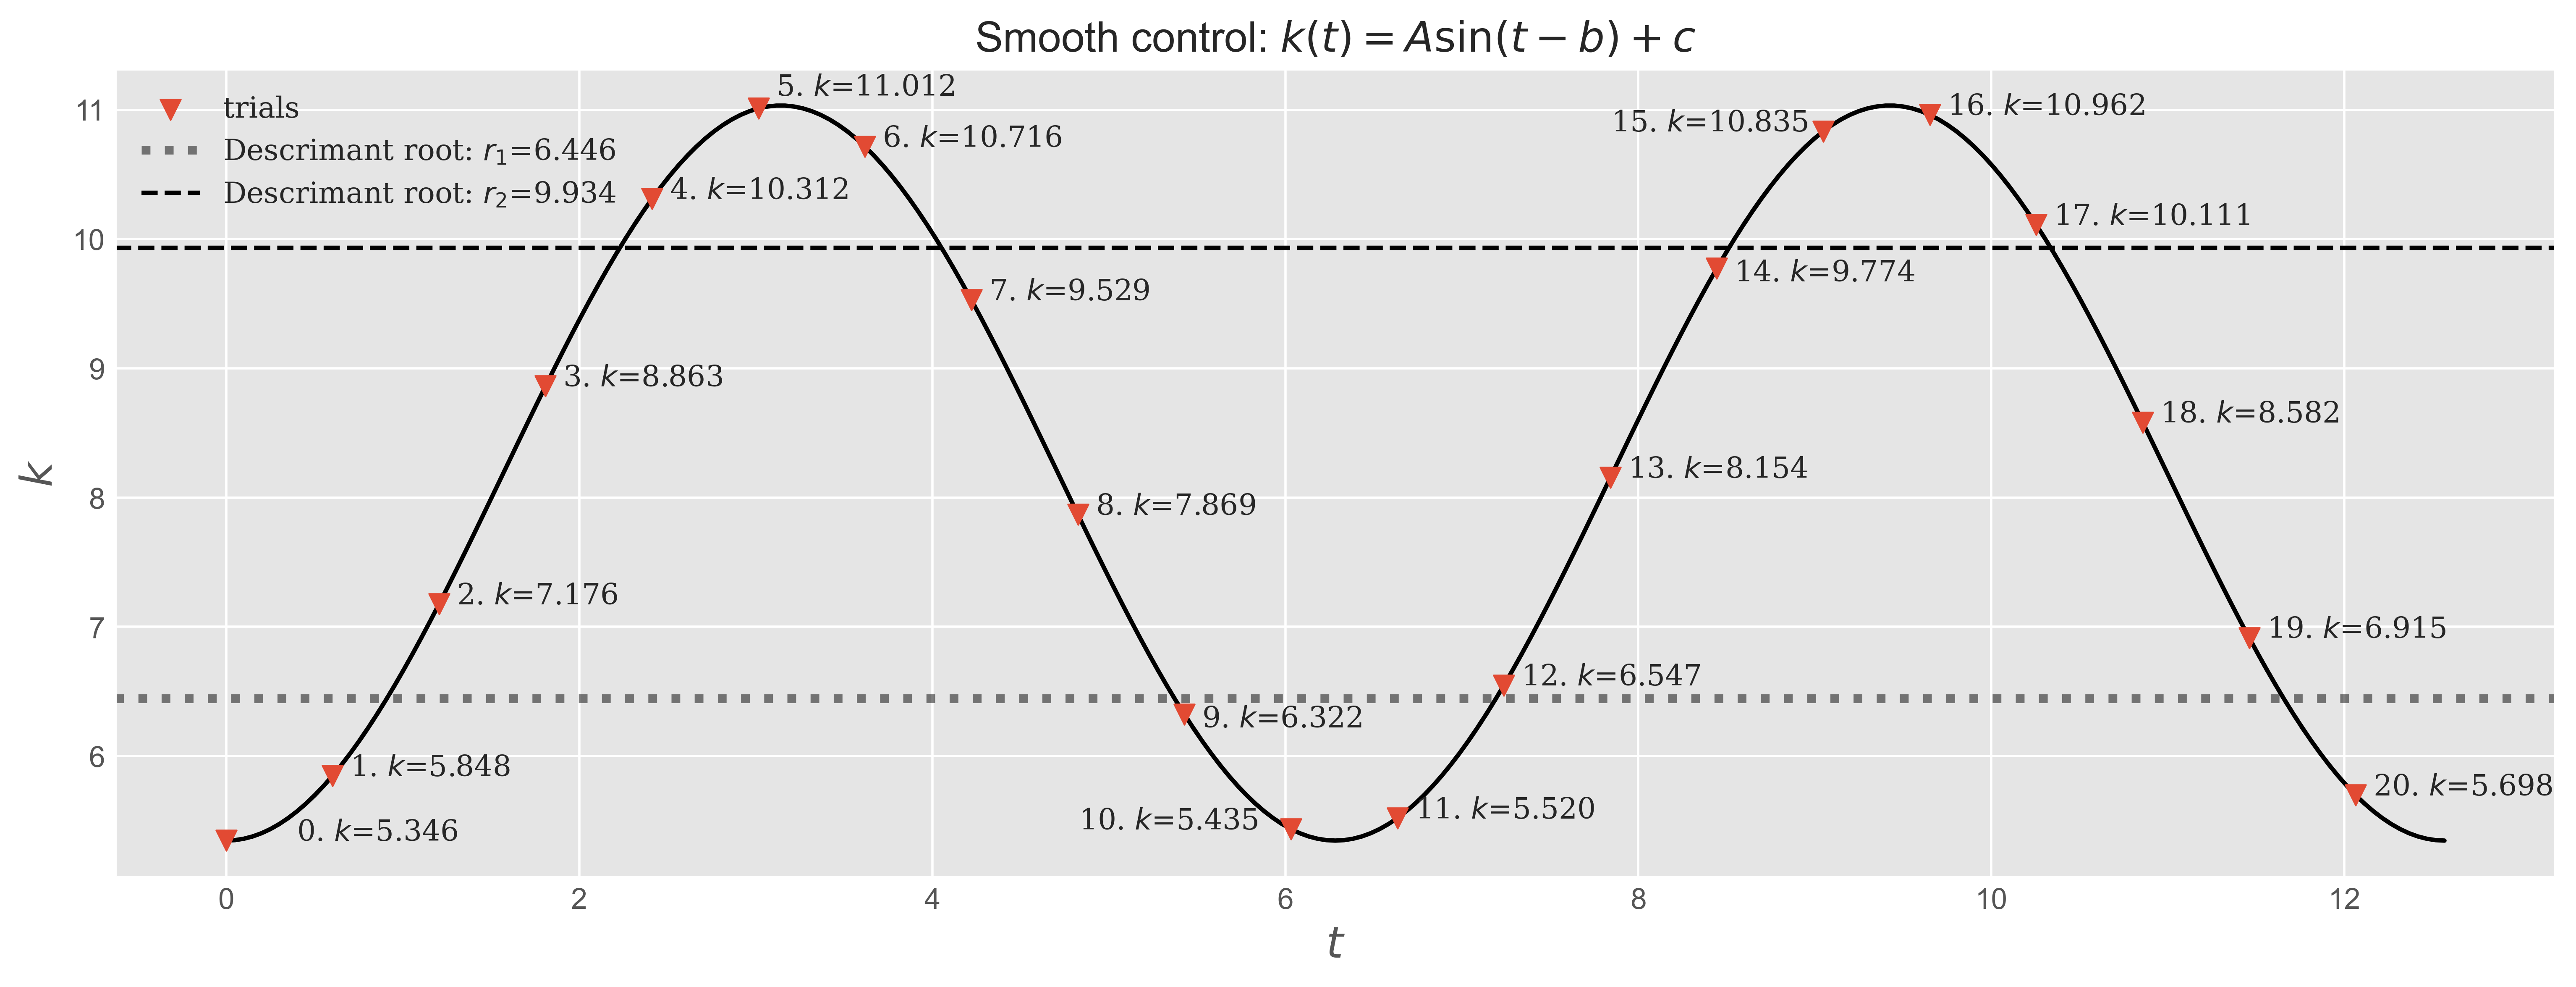

In [14]:
sample_rate = 12
t_span = np.linspace(0,4*np.pi,251)
t_trials = t_span[::sample_rate]
k_true = smooth_k(t_span)
k_trials = smooth_k(t_trials)


fig, ax = plt.subplots(1,1,figsize=(15,5),dpi=500)
t_span = np.linspace(0,4*np.pi,251)

ax.plot(t_span, k_true,c='black',zorder=1)
ax.scatter(
    t_span[::sample_rate],
    k_trials,
    label='trials',
    marker='v',
    s=50,
    zorder=2
)

for idx, (x,y) in enumerate(zip(t_span[::sample_rate],k_trials)):
    x_buff = 0.1
    if idx == 10 or idx == 15:
        x_buff = -1.2
    if idx == 0:
        x_buff = 0.4

    y_buff = 0
    if idx == 9 or idx == 14:
        y_buff = -0.1
    
    if idx == 5:
        y_buff = 0.1
    ax.text(x+x_buff,y+y_buff,s=rf'{idx}. $k$={y:.3f} ',family='serif',zorder=3)

ax.grid(True)
ax.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=3,zorder=1)
ax.axhline(r2, linestyle='--',c='black', label=rf"Descrimant root: $r_2$={r2:.3f}",zorder=1)
ax.set_ylabel(r"$k$", size=15)
ax.set_xlabel(r"$t$",size=15)
ax.set_title(r"Smooth control: $k(t) = A\sin(t-b)+c$")
ax.legend(prop={'family':'serif'})
if savefigs:
    plt.savefig(folder+f"budworm_smooth_control_{len(k_trials)}_k_trials.pdf")
plt.grid(True)
plt.show()

In [4]:
from data.budworm import simulate_trials, budworm_steady_states
import pickle

In [5]:
xs = np.linspace(0.1, 10, 51)

In [ ]:
# trials = {}


# for idx, ki in tqdm(enumerate(k_trials)):

#     ki_traj = []
#     ki_times= []

#     for x0 in tqdm(xs):
#         trial_ki = simulate_trials([ki],x0,dt=0.2,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501,show_progress=False)
#         ti = trial_ki.t_vals[0]
#         xi = trial_ki.x_vals[0]

#         ki_traj.append(xi)
#         ki_times.append(ti)

#     trials[f"trial_{idx}"] = {
#         "traj": ki_traj,
#         "times": ki_times,
#         "k": ki, 
#         "trial": idx
#     }


0it [00:00, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# path = "trials.pkl"

# with open(path, 'wb') as file:
#     pickle.dump(trials,file)

In [8]:
path = 'trials.pkl'

with open(path, 'rb') as file:
    trials = pickle.load(file)

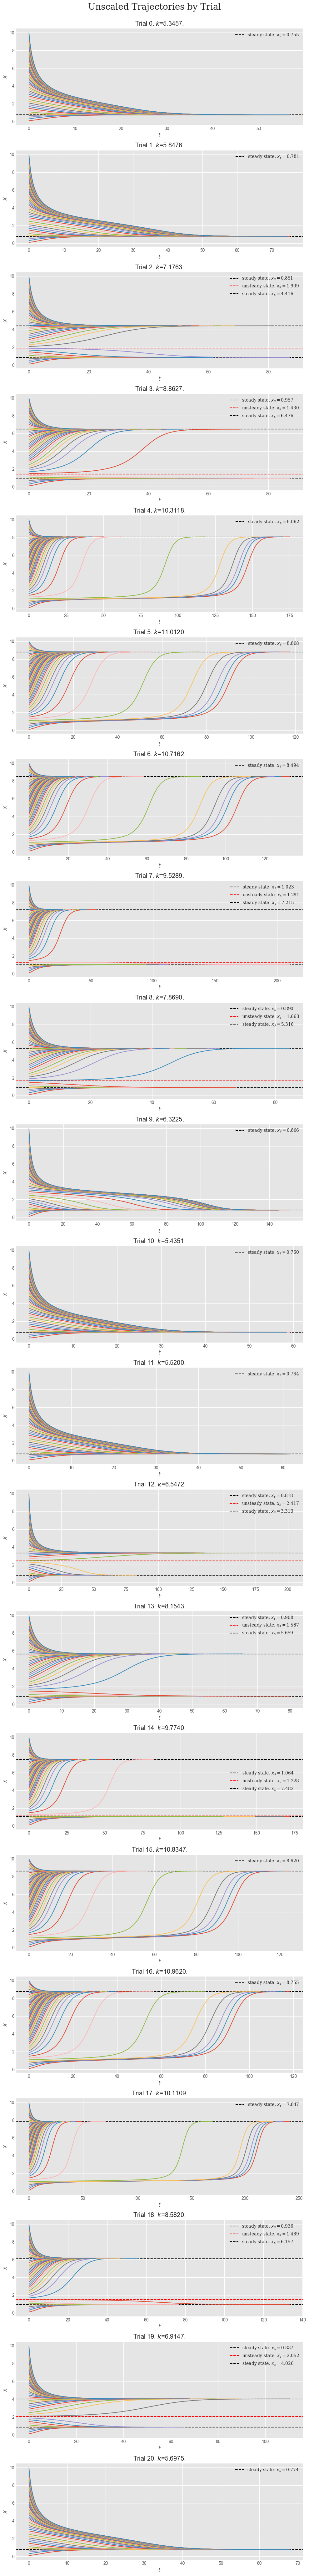

In [ ]:
cols = 1
rows = len(trials)

fig, axs = plt.subplots(rows, cols, figsize=(10*cols, 4*rows))

axs = axs.flatten()

for idx in range(rows):
    ax = axs[idx]
    trial_i = trials[f"trial_{idx}"]

    times = trial_i["times"]
    traj = trial_i["traj"]
    ki = trial_i["k"]

    for ti, xi in zip(times, traj):
        ax.plot(ti,xi)

    for idx2,xsi in enumerate(budworm_steady_states(ki,r=0.56)):
        label = rf"steady state. $x_s=${xsi:.3f}"
        color = 'black'
        if idx2 ==1:
            label = rf"unsteady state. $x_s=${xsi:.3f}"
            color = 'red'

        ax.axhline(
            xsi,
            xmin=0,
            c=color,
            linestyle="--",
            label=label,
            zorder=1
        )
    
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x$")
    ax.set_title(rf"Trial {idx}. $k$={ki:.4f}.")
    ax.legend(prop={'family':'serif'})




plt.suptitle("Unscaled Trajectories by Trial", family='serif',size=20)
plt.tight_layout(rect=[0,0,1,0.98])

if savefigs:
    file_name = f"unscaled_trajectories_num_k_{len(k_trials)}_num_x0_{len(xs)}.pdf"
    plt.savefig(folder+file_name)

plt.show()    


# Better model Trainer

In [19]:
from stabnode.node import StabNODE
from stabnode.utils import _load_loop_wrapper
from torchode import solve_ivp
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Optimizer

import torch.nn as nn
import time
import copy

from typing import Callable, Optional, Tuple
from pathlib import Path

In [20]:

def _save_model_opt_cpu(model:StabNODE, opt, epoch, loss, save_path:str, scheduler = None):
    device = next(model.parameters()).device.type
    f = model.f
    g = model.g
    f_args = f.args
    g_args = g.args

    if device  == "cpu":
        f_state = f.state_dict()
        g_state = g.state_dict()
        model_state = model.state_dict()
    else:
        f_cpu = copy.deepcopy(f).to('cpu')
        g_cpu = copy.deepcopy(g).to('cpu')
        model_cpu = StabNODE(f_cpu,g_cpu).to('cpu')

        f_state = f_cpu.state_dict()
        g_state = g_cpu.state_dict()
        model_state = model_cpu.state_dict()
    

    checkpoint = {
        "f_state_dict": f_state,
        "g_state_dict": g_state,
        "stabnode_state_dict": model_state,
        "f_args": f_args,
        "g_args":g_args,
        "opt_state_dict": opt.state_dict(),
        "epoch": epoch,
        "loss": loss,}

    if scheduler is not None:
        checkpoint["scheduler_state_dict"] = scheduler.state_dict()
    

    torch.save(checkpoint,save_path)
    
def _save_log_history(
        losses,
        times,
        stopping_criteria,
        best_model_epoch,
        method_status,
        patience_hist,
        save_path:str = None,
):
    log_history = {
        "losses": losses,
        "times": times,
        "stopping_criteria": stopping_criteria,
        "best_model_epoch": best_model_epoch,
        "method_status": method_status,
        "patience_hist": patience_hist,
    }

    if save_path is not None:
        with open(save_path, 'wb') as f: 
            pickle.dump(log_history, f)
    
    return log_history


def _create_save_paths(folder: str | Path):
    if folder is None:
        return None, None
    
    base_path = Path(folder)
    base_path.mkdir(parents=True, exist_ok=True)  # ensure folder exists

    # Define paths inside the folder
    model_opt_path = base_path / "model_opt_states.pt"
    log_path = base_path / "log_hist.pkl"

    return str(model_opt_path), str(log_path)


In [22]:
def model_trainer(
        model: StabNODE,
        opt: torch.optim.Optimizer,
        loss_criteria: Callable,
        train_loader: torch.utils.data.DataLoader,
        n_epochs: int,
        control: Callable[[torch.Tensor], torch.Tensor],
        min_improvement:float,
        patience: int,
        solve_method: str='tsit5', 
        save_folder: str|Path=None,
        show_progress:bool=True,
        scheduler: Optional[torch.optim.lr_scheduler._LRScheduler]=None,
        print_every: int=5,
        _precision: int = 4
)-> Tuple[StabNODE,dict]:
    
    loop_wrapper = _load_loop_wrapper(show_progress)
    model_opt_save_path, log_save_path = _create_save_paths(save_folder)

    best_loss = torch.inf
    patience_count = 0
    best_model_epoch = -1
    stopping_criteria = 'max-epochs'

    losses = []
    times = []
    status = []
    patience_hist = []
    model.train()
    for epoch in loop_wrapper(range(n_epochs)):
        t1 = time.time()
        epoch_loss = 0.0
        num_batches = 0
        epochs_status = []
        
        for Xi, Ti, x0i in train_loader:
            Xi = Xi.squeeze() # [batch, time, dim]
            Ti = Ti.squeeze()
            x0i = x0i.reshape(-1,1)

            if not x0i.requires_grad:
                x0i = x0i.clone().detach().requires_grad_()


            opt.zero_grad()

            sol = solve_ivp(
                f=lambda t, x: model(t, x, control),
                y0=x0i,
                t_eval=Ti,
                method=solve_method
            )

            epochs_status.append(sol.status)
            Xi_pred = sol.ys.squeeze()
            loss = loss_criteria(Xi_pred, Xi)

            loss.backward()
            opt.step()
            epoch_loss += loss.item()
            num_batches += 1

        if scheduler is not None:
            scheduler.step()


        
        epoch_loss = epoch_loss / num_batches
        cur_lr = opt.param_groups[0]['lr']
        epoch_time = time.time() - t1

        losses.append(epoch_loss)
        times.append(epoch_time)
        status.append(epochs_status)

        if show_progress:
            if epoch <= 5 or epoch % print_every == 0:
                print(f"Epoch {epoch}: Loss: {epoch_loss:.{_precision}f}. time = {epoch_time:.{_precision}f}s. lr = {cur_lr:.{_precision}f}")    
        
        # model checks
        if best_loss - epoch_loss >= min_improvement:
            best_loss = epoch_loss
            patience_count = 0
            best_model_epoch = epoch

            if save_folder is not None:
                _save_model_opt_cpu(
                    model,
                    opt,
                    best_model_epoch,
                    best_loss,
                    model_opt_save_path,
                    scheduler
                )

        else:
            patience_count += 1
        
        patience_hist.append(patience_count)

        if patience_count > patience:
            stopping_criteria = 'early-stoppage'
            if show_progress is not None:
                print(f"Patience exceeded: {patience}. Early stoppage executed.")
            break
        
        if save_folder is not None:
            _ = _save_log_history(
                losses,
                times,
                stopping_criteria=f"checkpoint-{epoch}",
                best_model_epoch=best_model_epoch,
                method_status=status,
                patience_hist=patience_hist,
                save_path = log_save_path
            )
        
    log_history = _save_log_history(
        losses,
        times,
        stopping_criteria,
        best_model_epoch,
        status,
        patience_hist,
        log_save_path,
    )

    return model, log_history

In [ ]:
n_epochs = 20
lr = 1e-2
show_progress = True
solve_method = 'dopri5'
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
# control_func = smooth_k
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

## test batching by trial

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
trail_0 = trials["trial_0"]

xs = trail_0['traj']
ts = trail_0['times']

scaler = MinMaxScaler()

scaler.fit(np.concatenate(xs).reshape(-1,1))

xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs]

In [31]:
scaler.data_max_, scaler.data_min_

(array([10.]), array([0.1]))

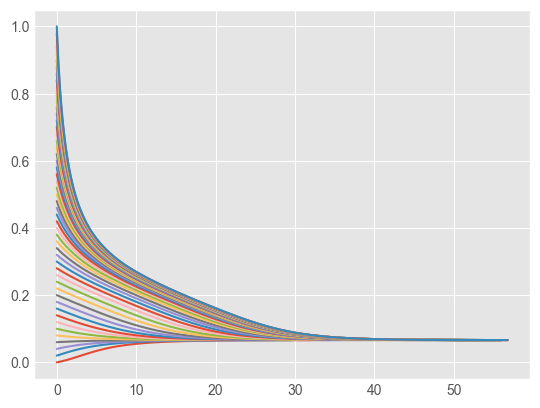

In [30]:
for ti, xi in zip(ts, xs_scaled):
    plt.plot(ti,xi)
plt.show()

In [32]:
for ti in ts:
    print(len(ti))

161
149
137
101
125
149
161
173
181
193
205
213
225
233
237
245
249
257
257
261
261
265
269
269
269
273
273
277
277
273
277
277
277
277
277
281
281
281
281
281
281
281
285
281
281
281
285
281
285
285
285


In [35]:
x0 = torch.tensor(
    [xi[0] for xi in xs_scaled], dtype=torch.float32
).reshape(-1,1)

In [36]:
t_max = None
t_max_len = -1
for ti in ts:
    if len(ti) > t_max_len:
        t_max = ti
        t_max_len = len(ti)

In [38]:
t_max = torch.tensor(t_max,dtype=torch.float32)

In [41]:
from stabnode.node import GeluSigmoid, FeluSigmoid, StabNODE
from stabnode.utils import set_global_seed

seed = 1234
set_global_seed(seed=seed)

In [ ]:
f = FeluSigmoid()

# Learning with `GeluSigmoid` and `FeluSigmoid`

increased dimensionality as well `hidden_dim = 6` for both
f_bounds -0.5 and -0.1 and g_bounds 

## Non bifurcation case

## bifrucaiton case

## All data